In [163]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import os
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
from pathlib import Path
from collections import Counter
from PIL import Image
import math
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

In [155]:
os.chdir('./../input')
os.chdir('./severstal-steel-defect-detection')
os.listdir()

['sample_submission.csv', 'test_images', 'train_images', 'train.csv']

In [ ]:
sub = pd.read_csv('sample_submission.csv')
train_csv = pd.read_csv('train.csv')

In [159]:
train_csv['ClassID'] = train_csv['ImageId_ClassId'].map(lambda x:str(x).split('_')[1])
train_csv['ImageID'] = train_csv['ImageId_ClassId'].map(lambda x:str(x).split('_')[0])

In [173]:
train_csv.head(6)

,ImageId_ClassId,EncodedPixels,ClassID,ImageID
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,2,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,3,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,4,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg
5,00031f466.jpg_2,NaN,2,00031f466.jpg


In [181]:
sub.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [186]:
with_defect = 0
no_defect = 0
class_dict = defaultdict(int)
kind_class_dict = defaultdict(int)

In [187]:
for col in range(0, len(train_csv), 4):
    img_names = [str(i).split("_")[0] for i in train_csv.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
    labels = train_csv.iloc[col:col+4,1]
    if labels.isna().all():
        no_defect += 1
    else:
        with_defect += 1
    kind_class_dict[sum(labels.isna().values == False)] += 1
    for idx,label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [188]:
print(f'Images with defects : {with_defect}')
print(f'Images with no defect : {no_defect}')

Images with defects : 6666
Images with no defect : 5902


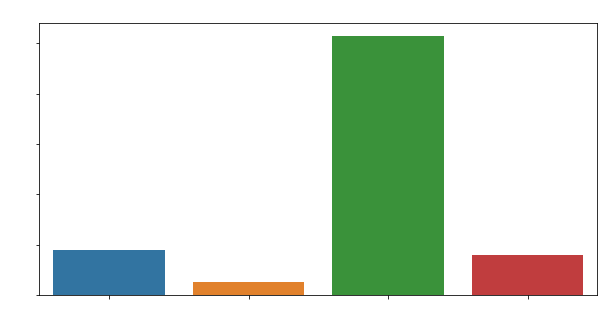

In [189]:
plt.figure(figsize=(10,5))
sns.barplot(x = list(class_dict.keys()),y = list(class_dict.values()))
plt.title('No of images for each class',color='white')
plt.xlabel('Class',color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

From the above barplot it can be clearly seen that the image data is **highly imbalanced**.Majority of the images contains Defect-3 in the steel.And the least in Defect-2

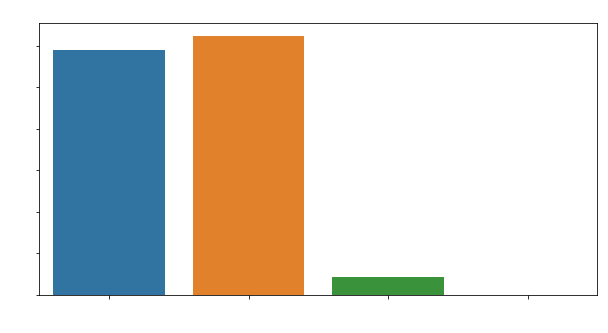

In [190]:
plt.figure(figsize=(10,5))
sns.barplot(x = list(kind_class_dict.keys()),y = list(kind_class_dict.values()))
plt.title('No of classes for each image',color='white')
plt.xlabel('Class',color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

So majority of the image contains upto none or 1 defect in each images.There is no 3 defects shown in any one of the image

**Checking Image data**

In [191]:
train_img_dict = defaultdict(int)
test_img_dict = defaultdict(int)

In [192]:
train_path = Path('./train_images')
test_path = Path('./test_images')

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_img_dict[img.size] += 1
    
for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_img_dict[img.size] += 1

**Utilty Functions**

In [ ]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [201]:
train = train_csv[train_csv['EncodedPixels'].notnull()]
train.shape

(7095, 5)

KeyboardInterrupt: 

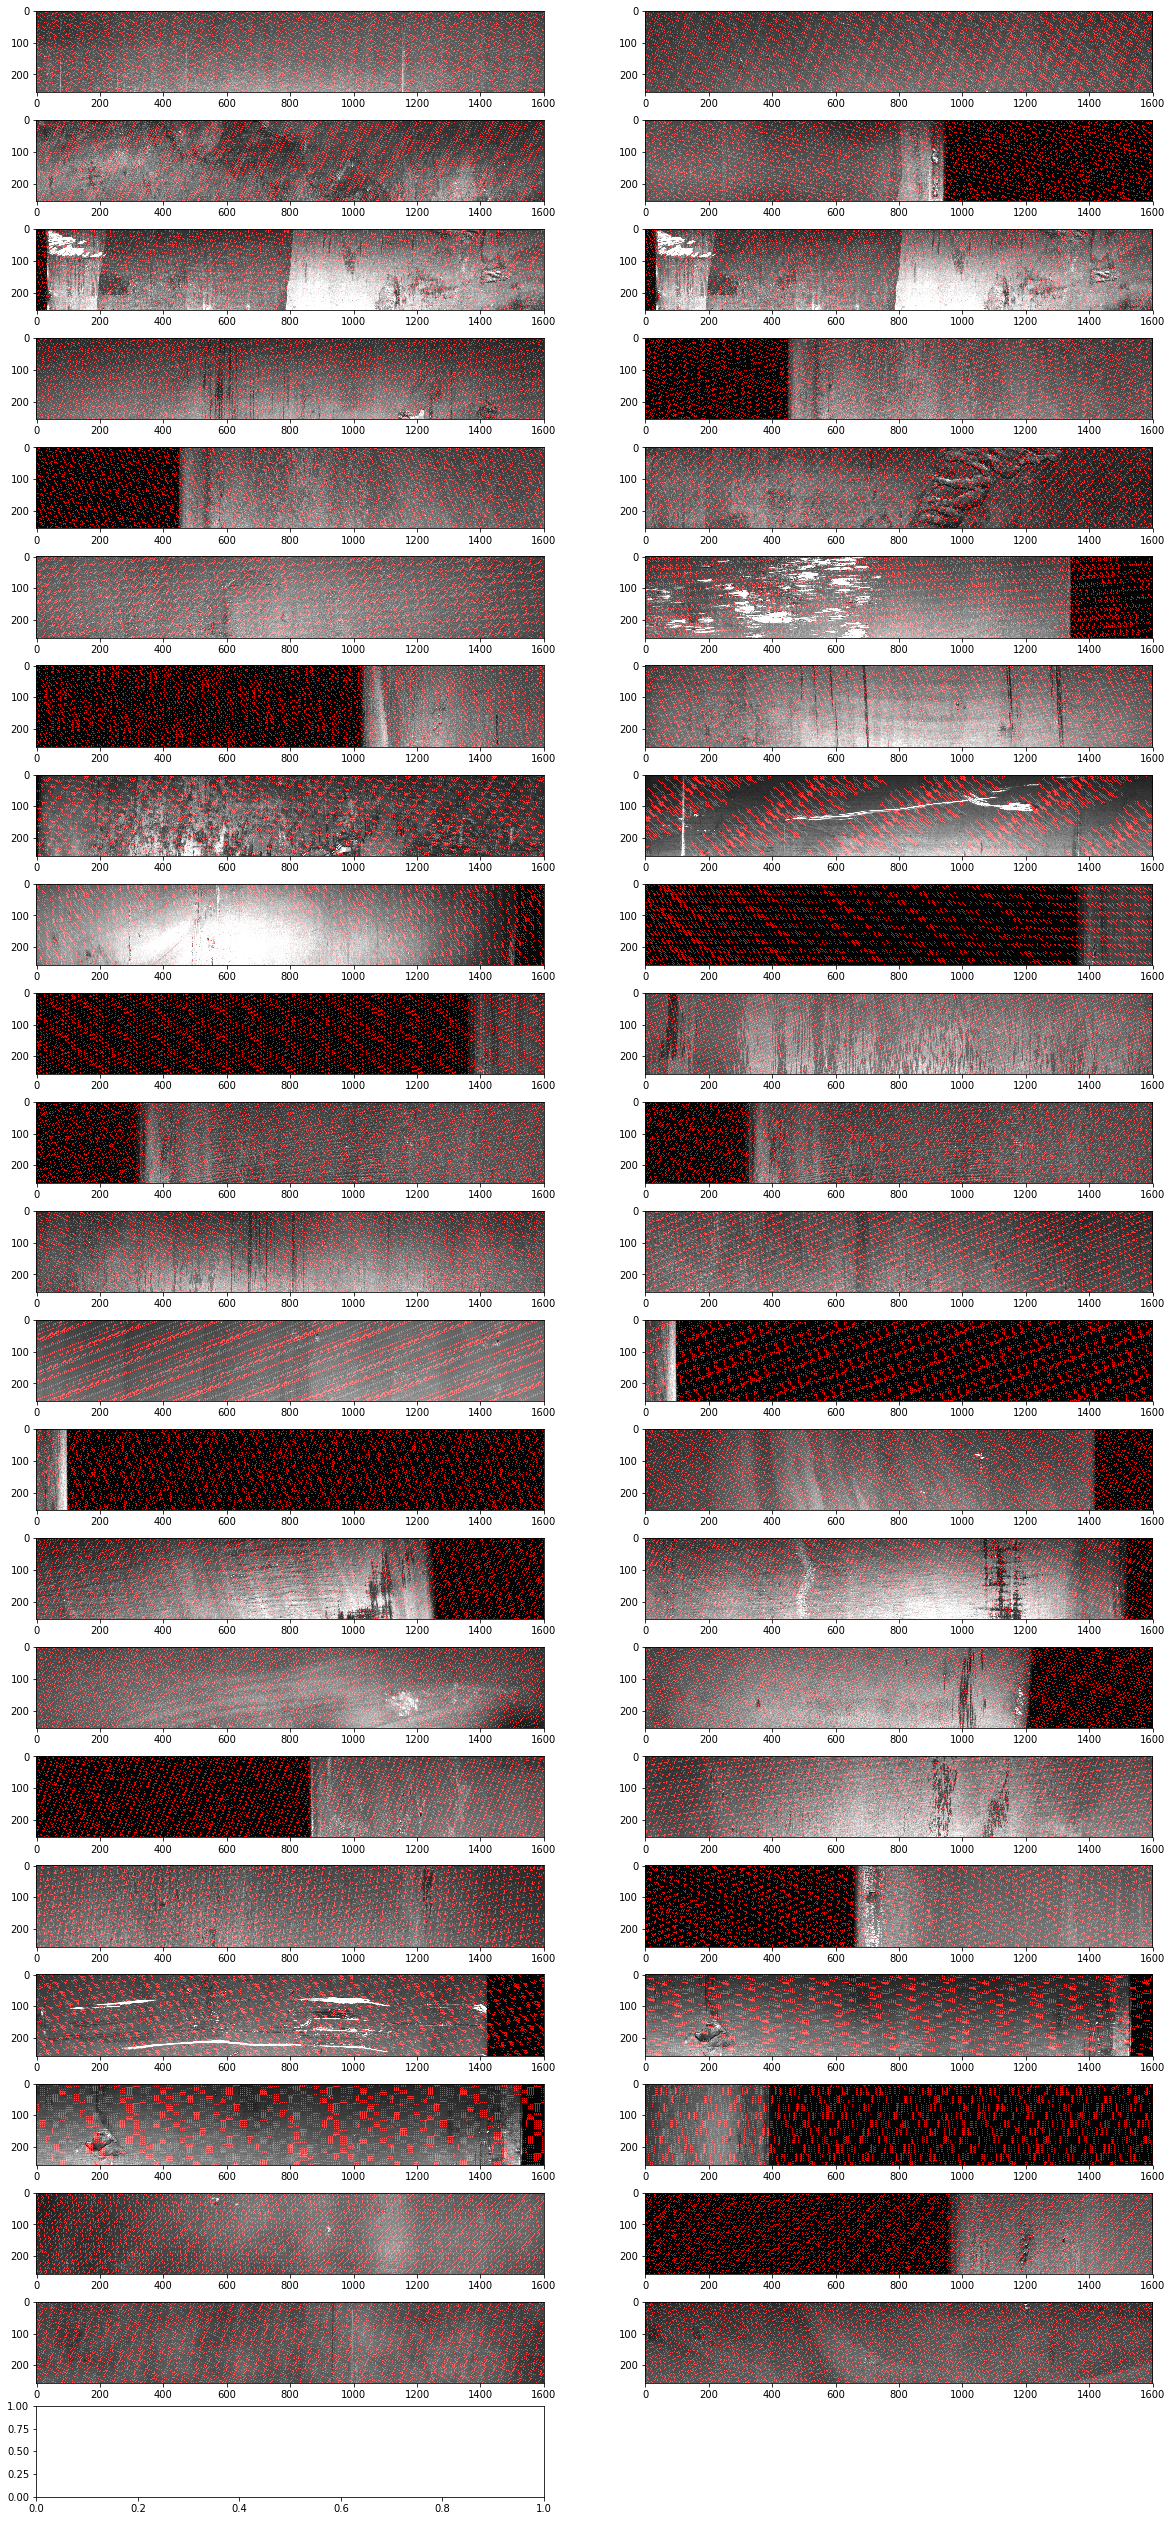

In [202]:
fig = plt.figure(figsize=(20,100))
rows = 50
cols = 2
for i in range(1,100+1):
    fig.add_subplot(rows,cols,i)
    fn = train['ImageId_ClassId'].iloc[i].split('_')[0]
    img = cv.imread(f'./train_images/{fn}')
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    mask = rle2mask(train['EncodedPixels'].iloc[i],img.shape)
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()